In [1]:
!pip install sentencepiece
#!pip install fastai==1.0.57
#!pip install torch==1.1.0
!pip install emoji
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
import os
import numpy
import pandas as pd
import re
import glob
import emoji as em


from fastai.text import *
import numpy as np
from sklearn.model_selection import train_test_split
import pickle
import sentencepiece as spm
import re
import pdb



     |████████████████████████████████| 1.1MB 10.4MB/s 
     |████████████████████████████████| 51kB 5.6MB/s 
  Created wheel for emoji: filename=emoji-0.6.0-cp36-none-any.whl size=49716 sha256=bc34611419dacdcc8314871b593ffed1a4a9bd227146d697bcfae9670a4d5e67
  Stored in directory: /root/.cache/pip/wheels/46/2c/8b/9dcf5216ca68e14e0320e283692dce8ae321cdc01e73e17796
Successfully built emoji
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [2]:
path = Path('/content/drive/My Drive/knen')

In [4]:
df = pd.read_csv(path/'data/Dataset.csv')

df.head()

,word,tag
0,alla,kn
1,kopista,kn
2,baruthe,kn
3,coolagiru,en-kn
4,madhuswamy,name


In [5]:
from sklearn.model_selection import train_test_split
train_df,valid_df=train_test_split(df,test_size=0.3)

In [6]:
print('In Training data:')
for cls in train_df['tag'].unique():
    print(cls, (train_df['tag'] == cls).sum())

In Training data:
kn 6054
en 4457
other 1215
en-kn 1021
name 756
location 99


In [7]:
print('In test data:')
for cls in valid_df['tag'].unique():
    print(cls, (valid_df['tag'] == cls).sum())

In test data:
en-kn 451
en 1825
kn 2666
other 548
name 306
location 34


In [8]:
train_df.shape, valid_df.shape

((13602, 2), (5830, 2))

In [9]:
train_df[train_df['word'].isnull()].shape, valid_df[valid_df['word'].isnull()].shape

((0, 2), (0, 2))

In [10]:
label_cols = [1]

In [11]:
id_to_col = list(train_df.columns)

In [12]:
col_to_id = {}
for i, col in enumerate(id_to_col):
    col_to_id[col] = i

In [13]:
class kaenTokenizer(BaseTokenizer):
    def __init__(self, lang:str):
        self.lang = lang
        self.sp = spm.SentencePieceProcessor()
        self.sp.Load(str(path/"tokenizer/kn_en_spm_10k.model"))
        
    def tokenizer(self, t:str) -> List[str]:
        return self.sp.EncodeAsPieces(t)

In [14]:
sp = spm.SentencePieceProcessor()
sp.Load(str(path/"tokenizer/kn_en_spm_10k.model"))
itos = [sp.IdToPiece(int(i)) for i in range(10000)]

In [15]:
vocab = Vocab(itos)

In [16]:
tokenizer = Tokenizer(tok_func=kaenTokenizer, lang='kaen')

In [17]:
tokenizer.special_cases

['xxunk',
 'xxpad',
 'xxbos',
 'xxeos',
 'xxfld',
 'xxmaj',
 'xxup',
 'xxrep',
 'xxwrep']

In [18]:
data_lm = TextLMDataBunch.from_df(path=path, train_df=train_df, valid_df=valid_df, text_cols=[0], label_cols=label_cols, tokenizer=tokenizer, vocab=vocab, bs=16)

In [19]:
data_lm.save()
data_lm.show_batch()

/usr/local/lib/python3.6/dist-packages/fastai/text/data.py:339: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:766.)
  idx_min = (t != self.pad_idx).nonzero().min()


idx,text
0,▁hagu ravagi ▁xx bo s ▁v u cha ▁xx bo s ▁frustrat ed agide ▁xx bo s ▁irritat ed ▁xx bo s ▁suit s ▁xx bo s ▁leee ▁xx bo s ▁humble agi ru ▁xx bo s ▁madle beku ▁xx bo s ▁t es a iga ri ▁xx bo s ▁thousand ▁xx bo s ▁nindu ▁xx bo s ▁adi ro ▁xx bo s ▁maduva ▁xx bo s ▁ninu n ▁xx
1,bo s ▁stand ing ▁xx bo s ▁tol kolo ▁xx bo s ▁insert ▁xx bo s ▁ankond id na ▁xx bo s ▁mit ta i ▁xx bo s ▁whole ▁xx bo s ▁ ed dhe ▁xx bo s ▁eno e x ic ite ment ▁xx bo s ▁ekd a ▁xx bo s ▁sab ka ▁xx bo s ▁madhu ▁xx bo s ▁ <unk> ▁xx bo s ▁lga ▁xx bo s
2,▁eith er ▁xx bo s ▁nayan a ▁xx bo s ▁gh e e ta ▁xx bo s ▁i iga ▁xx bo s ▁ak s hara s a ha ▁xx bo s ▁l ma o ▁xx bo s ▁oor kade ne ▁xx bo s ▁last ly ▁xx bo s ▁anchor s ▁xx bo s ▁content s ▁xx bo s ▁nodo dhe ▁xx bo s ▁bad lu ▁xx bo s ▁agthira ▁xx
3,▁xx bo s ▁cha giro ▁xx bo s ▁bare de yo ▁xx bo s ▁vishnuvardhan ▁xx bo s ▁agute ▁xx bo s ▁kan le ▁xx bo s ▁hid kol li ▁xx bo s ▁kur e ▁xx bo s ▁maatra ▁xx bo s ▁mon ne ▁xx bo s ▁wid er ▁xx bo s ▁yapp ▁xx re p ▁ <unk> ▁a ▁xx bo s ▁ mangla r ti ▁xx bo s ▁hot
4,▁xx bo s ▁h na ge ▁xx bo s ▁re noo ▁xx bo s ▁brasta ▁xx bo s ▁com ra d ▁xx bo s ▁net s igu di la ▁xx bo s ▁ki kumar d ▁xx bo s ▁plan madi dare ▁xx bo s ▁mak ala in ▁xx bo s ▁ ed m ▁xx bo s ▁force full y ▁xx bo s ▁ishta r ▁xx bo s ▁suja n ▁xx


In [20]:
awd_lstm_config = awd_lstm_lm_config.copy()
awd_lstm_config['n_hid'] = 1152
learn = language_model_learner(data_lm, arch=AWD_LSTM, drop_mult=0.3, config=awd_lstm_config, pretrained=False)

In [21]:
learn.load (path/'lm/ken')


RuntimeError: ignored

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


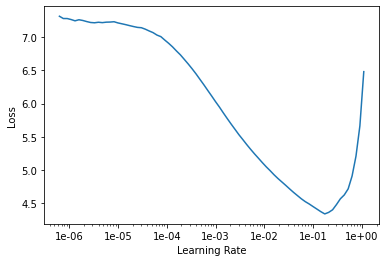

In [ ]:
learn.lr_find()
learn.recorder.plot()


In [ ]:

learn.freeze()
learn.fit_one_cycle(4, 1e-2)
learn.unfreeze()
learn.fit_one_cycle(8, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,4.660027,3.112709,0.616623,00:05
1,3.161017,2.863539,0.633009,00:05
2,2.755710,2.836149,0.632274,00:05
3,2.576510,2.825421,0.631959,00:05


epoch,train_loss,valid_loss,accuracy,time
0,2.467036,2.750190,0.634848,00:06
1,2.441152,2.722022,0.636633,00:06
2,2.432564,2.717787,0.635137,00:06
3,2.379326,2.742685,0.635714,00:06
4,2.330758,2.753878,0.633850,00:06
5,2.291694,2.771746,0.633193,00:06
6,2.270932,2.776886,0.632826,00:06
7,2.246808,2.784168,0.632405,00:06


In [ ]:
learn.save_encoder('fine_tuned_enc')

In [ ]:
data_clas = TextClasDataBunch.from_df(path=path, train_df=train_df, valid_df=valid_df, tokenizer=tokenizer, vocab=vocab, text_cols=[0], label_cols=label_cols, bs=16)

In [ ]:
data_clas.show_batch()

text,target
▁x x bo s ▁x x re p ▁ <unk> ▁d ▁f ▁x x re p ▁ <unk> ▁d ▁ ff ▁x x re p ▁ <unk> ▁d,other
▁x x bo s ▁ u ▁x x re p ▁ <unk> ▁m ▁ nnn mm,en
▁x x bo s ▁s ▁x x re p ▁ <unk> ▁ u ▁per,en
▁x x bo s ▁a yyy ▁x x re p ▁ <unk> ▁o,kn
▁x x bo s ▁adi chu ru van ga po la ye,other


In [ ]:
learn = text_classifier_learner(data_clas, arch=AWD_LSTM, drop_mult=0.5, config=awd_lstm_config)

In [ ]:
learn.load_encoder('fine_tuned_enc')


RNNLearner(data=TextClasDataBunch;

Train: LabelList (13602 items)
x: TextList
▁x x bo s ▁immediat ely,▁x x bo s ▁do o ly,▁x x bo s ▁come,▁x x bo s ▁cl ama giri,▁x x bo s ▁ cause
y: CategoryList
en,name,en,en-kn,en
Path: /content/drive/My Drive/knen;

Valid: LabelList (5830 items)
x: TextList
▁x x bo s ▁memor y,▁x x bo s ▁za ng,▁x x bo s ▁kadda di gan u,▁x x bo s ▁ka neeru,▁x x bo s ▁hinde
y: CategoryList
en,other,kn,kn,kn
Path: /content/drive/My Drive/knen;

Test: None, model=SequentialRNN(
  (0): MultiBatchEncoder(
    (module): AWD_LSTM(
      (encoder): Embedding(8000, 400, padding_idx=1)
      (encoder_dp): EmbeddingDropout(
        (emb): Embedding(8000, 400, padding_idx=1)
      )
      (rnns): ModuleList(
        (0): WeightDropout(
          (module): LSTM(400, 1152, batch_first=True)
        )
        (1): WeightDropout(
          (module): LSTM(1152, 1152, batch_first=True)
        )
        (2): WeightDropout(
          (module): LSTM(1152, 400, batch_first=True)
        )


epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


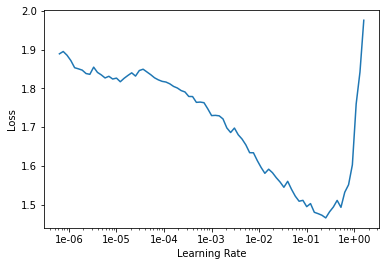

In [ ]:
learn.freeze()
learn.lr_find()
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(4, 1e-2)
learn.freeze_to(-2)
learn.fit_one_cycle(8, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.980463,0.895646,0.702744,00:09
1,0.866977,0.833932,0.722813,00:09
2,0.835903,0.884240,0.713208,00:09
3,0.831258,0.821353,0.722642,00:09


epoch,train_loss,valid_loss,accuracy,time
0,0.840704,2.105515,0.718696,00:10
1,0.857962,1.528408,0.707376,00:10
2,0.850914,1.652109,0.680961,00:10
3,0.813684,1.564834,0.718868,00:10
4,0.826840,3.368390,0.718353,00:10
5,0.807370,9.088012,0.736535,00:10
6,0.776708,1.608406,0.709777,00:10
7,0.768767,1.689026,0.718868,00:10


In [ ]:


learn.unfreeze()
learn.fit_one_cycle(20, 1e-3, callbacks=[callbacks.SaveModelCallback(learn, every='improvement', monitor='accuracy', name='final')])



epoch,train_loss,valid_loss,accuracy,time
0,0.398027,0.648477,0.801201,00:16
1,0.420058,0.672224,0.796569,00:17
2,0.441402,1.306629,0.792796,00:16
3,0.408954,0.747774,0.791252,00:16
4,0.412685,1.325287,0.782847,00:16
5,0.427800,5.059669,0.777187,00:16
6,0.364192,0.949664,0.785420,00:16
7,0.329588,1.124733,0.784906,00:16
8,0.264310,0.814242,0.781304,00:16
9,0.239713,1.614189,0.779074,00:16


Better model found at epoch 0 with accuracy value: 0.8012006878852844.


In [ ]:
pred1 = valid_df['word'].apply(lambda row: str(learn.predict(row)[0]))


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(pred1,valid_df.tag))

              precision    recall  f1-score   support

          en       0.86      0.85      0.86      1920
       en-kn       0.86      0.83      0.84       462
          kn       0.88      0.83      0.85      2762
    location       0.00      0.00      0.00         0
        name       0.48      0.49      0.49       318
       other       0.39      0.55      0.46       368

    accuracy                           0.80      5830
   macro avg       0.58      0.59      0.58      5830
weighted avg       0.82      0.80      0.81      5830



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
learn.export(path/'kaen_model.pkl')
